# Robustness and Exploration of Variational and Machine Learning Approaches to Inverse Problems

## Imports and setup

In [2]:
%reload_ext autoreload
%autoreload 2

import os
import random
from typing import Callable, Literal, Sequence, Tuple, Union

import matplotlib.pyplot  as plt
import numpy as np
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchopt
from tqdm.auto import tqdm, trange

plt.rcParams.update({
    "text.usetex": True,
    "font.family" : "sans-serif",
    "font.weight" : "bold",
    "font.size"   : 22
})

torch.set_grad_enabled(False)

def seed(seed: int):
    seed = seed%2^32
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms(True, warn_only=True)

## Configuration

In [3]:
SEED = 314176
seed(SEED)
DEVICE = torch.device("cuda:0")
NUM_WORKERS = 0 #os.cpu_count()

N_TRAIN_SAMPLES = 1024 # 64% * 1600
N_VAL_SAMPLES = 256    # 16% * 1600
N_TEST_SAMPLES = 320   # 20% * 1600
NOISE_LEVEL = 0.03 # 0.0
GRAD_BATCH_SIZE = 128
NOGRAD_BATCH_SIZE = 4096

DATA_SIZE = 1008
MEASUREMENT_SIZE = 504

In [4]:
TV_SOLVER = lambda x: globals()["tv_admm"](x)
# SGD
#TV_LR = 3e-2
#TV_ALPHA = 1e1
#TV_ITERATIONS = 1000
# ADMM
TV_ITERATIONS = 2_000
TV_LAMBDA = 1e0
TV_ALPHA = 3e0
# PDHG 1
#TV_ALPHA = 1e-2
#TV_ITERATIONS = 50
#TV_TAU = 1e2
#TV_SIGMA = TV_TAU
# PDHG 2
#TV_ITERATIONS = 5000
#TV_TAU = 9e-4
#TV_SIGMA = TV_TAU
#TV_ALPHA = 1e1


TV_ADV_LR = 1e0
TV_ADV_ITERATIONS = 10
TV_ADV_EPSILON = 1.0

In [5]:
UNET_LR = 1e-5
UNET_EPOCHS = 20
UNET_TIK_ALPHA = 0.1

UNET_ADV_LR = 1e-3
UNET_ADV_ITERATIONS = 10
UNET_ADV_EPSILON = 1e-1

## Operators

In [6]:
#__A = torch.eye(DATA_SIZE, device=DEVICE).unsqueeze(0)
__A = 0.05*torch.randn((MEASUREMENT_SIZE,DATA_SIZE), device=DEVICE).unsqueeze(0)
__tmp = __A@torch.tril(torch.ones((1,DATA_SIZE,DATA_SIZE), device=DEVICE))
__ATApIi = (__tmp.mT@__tmp + torch.eye(DATA_SIZE, device=DEVICE)).inverse()
__lATApIi = ((TV_LAMBDA if "TV_LAMBDA" in globals().keys() else 1.0)*__tmp.mT@__tmp + torch.eye(DATA_SIZE, device=DEVICE)).inverse()
__D = torch.eye(DATA_SIZE, device=DEVICE)-torch.diag(torch.ones((DATA_SIZE-1), device=DEVICE), -1).unsqueeze(0)
__ATApaD2iAT = (__A.mT@__A+UNET_TIK_ALPHA*__D.mT@__D).inverse()@__A.mT  # USE __tmp instead of __A?
A = lambda x: (__A@x.cumsum(1).unsqueeze(-1))[...,0]
A_T = lambda x: (__A.mT@x.unsqueeze(-1))[...,0].flip(1).cumsum(1).flip(1)
ATApIi = lambda x: (__ATApIi@x.unsqueeze(-1))[...,0]
lATApIi = lambda x: (__lATApIi@x.unsqueeze(-1))[...,0]
A_pinv = lambda x: (__ATApaD2iAT@x.unsqueeze(-1))[...,0]

#x = torch.randn((1,DATA_SIZE), device=DEVICE)
#y = torch.randn((1,MEASUREMENT_SIZE), device=DEVICE)
#print(torch.sum(A(x)*y)-torch.sum(A_T(y)*x))

/tmp/ipykernel_174602/1857394767.py:3: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:156.)
  __tmp = __A@torch.tril(torch.ones((1,DATA_SIZE,DATA_SIZE), device=DEVICE))
/tmp/ipykernel_174602/1857394767.py:4: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To 

## Data generation

In [11]:
def generate_signals(
    N_samples: int,
    noise_level: float = 0.03,
    N_signal: int = 1000,
    min_jumps: int = 10, 
    max_jumps: int = 20, 
    min_distance: int = 40, 
    boundary_width: int = 20, 
    height_std: float = 1.0,
    min_height: float = 0.2
) -> Tensor:
    #Calculate positions by generating min_distance-spaced positions
    #and randomly rightshifting by the cumulatice sum
    derivative = torch.zeros((N_samples,N_signal), device=DEVICE)
    for i in range(N_samples):
        jump_count = random.randint(min_jumps-2, max_jumps-2)
        delta = torch.rand((jump_count-1), device=DEVICE) # One more than needed (last will be discarded, as it would lead to using the right boundary as last value, due to the normalization)
        delta = torch.cumsum((N_signal-2*boundary_width-(jump_count-2)*min_distance)*delta/delta.sum(), 0)[:-1].ceil().to(torch.long)
        jump_positions = boundary_width+min_distance*torch.arange(jump_count-2, device=DEVICE)+delta.sort()[0]
        values = height_std*torch.randn((jump_count,), device=DEVICE)
        values[torch.abs(values)<min_height] = values[torch.abs(values)<min_height].sign()*min_height
        derivative[i,torch.cat([torch.tensor([0], device=DEVICE),jump_positions,torch.tensor([0], device=DEVICE)])] = values
    groundtruths = derivative
    measurements = A(groundtruths)
    noisy_measurement = measurements+noise_level*torch.randn_like(measurements)
    return noisy_measurement, groundtruths

/tmp/ipykernel_174602/4215437499.py:18: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:71.)
  delta = torch.cumsum((N_signal-2*boundary_width-(jump_count-2)*min_distance)*delta/delta.sum(), 0)[:-1].ceil().to(torch.long)
/tmp/ipykernel_174602/4215437499.py:23: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:71.)
  groundtruths = derivative.cumsum(1)
/tmp/ipykernel_174602/1857394767.py:8: UserWarning: cumsum_c

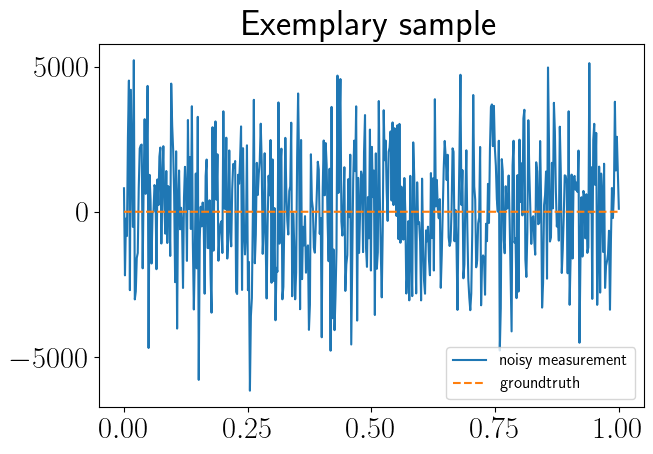

In [12]:
train_dataset = TensorDataset(*generate_signals(N_TRAIN_SAMPLES, noise_level=NOISE_LEVEL, N_signal=DATA_SIZE))
val_dataset = TensorDataset(*generate_signals(N_VAL_SAMPLES, noise_level=NOISE_LEVEL, N_signal=DATA_SIZE))
test_dataset = TensorDataset(*generate_signals(N_TEST_SAMPLES, noise_level=NOISE_LEVEL, N_signal=DATA_SIZE))
train_dataloader = DataLoader(train_dataset, batch_size=GRAD_BATCH_SIZE, shuffle=True, drop_last=False, num_workers=NUM_WORKERS, worker_init_fn=lambda _: seed(torch.initial_seed()))
val_dataloader = DataLoader(val_dataset, batch_size=NOGRAD_BATCH_SIZE, shuffle=False, drop_last=False, num_workers=NUM_WORKERS, worker_init_fn=lambda _: seed(torch.initial_seed()))
test_dataloader = DataLoader(test_dataset, batch_size=NOGRAD_BATCH_SIZE, shuffle=False, drop_last=False, num_workers=NUM_WORKERS, worker_init_fn=lambda _: seed(torch.initial_seed()))

noisy_measurement, groundtruth = train_dataset[0]
plt.figure(figsize=(7,5))
plt.title("Exemplary sample")
plt.plot(torch.linspace(0.0, 1.0, noisy_measurement.shape[0]), noisy_measurement.detach().to("cpu").numpy(), label="noisy measurement")
plt.plot(torch.linspace(0.0, 1.0, groundtruth.shape[0]), groundtruth.detach().to("cpu").numpy(), "--", label="groundtruth")
plt.legend(prop={"size": 12})
plt.tight_layout()
plt.show()

## Utilities

In [13]:
class TensorModule(nn.Module):
    def __init__(self, initial_value: Tensor) -> None:
        super().__init__()
        self.__tensor = torch.nn.parameter.Parameter(initial_value)
    
    @property
    def tensor(self) -> torch.Tensor:
        return self.__tensor

In [14]:
def mean_bregman_distance(a: Tensor, b: Tensor, convex_function: Callable[[Tensor],Tensor], symmetric: bool = False) -> Tensor:
    a = a.clone()
    a.requires_grad = True
    b = b.clone()
    b.requires_grad = True
    with torch.enable_grad():
        grad_a = torch.autograd.grad(convex_function(a), a)[0]
        grad_b = torch.autograd.grad(convex_function(b), b)[0]
    if symmetric:
        return ((grad_a-grad_b)*(a-b)).sum(dim=1).mean()
    return (convex_function(a) - convex_function(b) - (grad_b*(a-b)).sum(dim=1)).mean()

In [15]:
def total_variation(x: Tensor) -> Tensor:
    return F.conv1d(x.unsqueeze(1), torch.tensor([[[-1.0,1.0,0.0]]], device=DEVICE), padding=1).abs().mean()

## Algorithms

### TV-Regularized energy minimization

#### Solvers

In [11]:
def tv_gd(noisy_measurement: Tensor) -> Tuple[Tensor,float]:
    reconstruction = TensorModule(torch.zeros((noisy_measurement.shape[0], DATA_SIZE), device=DEVICE))
    optimizer = torchopt.MetaAdam(reconstruction, lr=TV_LR)
    with torch.enable_grad():
        for _ in range(TV_ITERATIONS):
            loss = F.mse_loss(A(reconstruction.tensor), noisy_measurement) + TV_ALPHA*total_variation(reconstruction.tensor)
            optimizer.step(loss)
    return reconstruction.tensor, loss.item(), None

https://www.stat.cmu.edu/~ryantibs/convexopt-F18/lectures/admm.pdf
$$
\argmin_u \frac{1}{2}\|Au-f\|_2^2 + \alpha\|u\|_1 = \argmin_u G(u) + F(u)\\
G(u) = \frac{1}{2}\|Au-f\|_2^2\\
%\operatorname{prox}_{\lambda G}(u) = (A^TA+I)^{-1}(\frac{u+A^Tf}{\lambda})\\
\operatorname{prox}_{\lambda G}(u) = (\lambda A^TA+I)^{-1}(u+\lambda A^Tf)\\
F(u) = \alpha\|u\|_1\\
\operatorname{prox}_{\lambda F}(u) = \operatorname{sign}(u)\max(|u|-\lambda\alpha,0)
$$

In [12]:
def tv_admm(noisy_measurement: Tensor) -> Tuple[Tensor,float]:
    #prox_G = lambda u: ATApIi((u+A_T(noisy_measurement))/TV_LAMBDA)
    prox_G = lambda u: lATApIi(u+TV_LAMBDA*A_T(noisy_measurement))
    prox_F = lambda u: u.sign()*torch.clamp(u.abs()-TV_LAMBDA*TV_ALPHA, 0.0)
    x = torch.zeros((noisy_measurement.shape[0], DATA_SIZE), device=DEVICE)
    y = torch.zeros((noisy_measurement.shape[0], DATA_SIZE), device=DEVICE)
    z = torch.zeros((noisy_measurement.shape[0], DATA_SIZE), device=DEVICE)
    for i in range(TV_ITERATIONS):
        x = prox_F(y-z)
        y = prox_G(x+z)
        z = z+x-y
        #if i%100==0:
        #    print(torch.sum(torch.abs(y[0]-x[0])))
        #    print(torch.sum((-z/TV_ALPHA)[0]*y[0] - torch.abs(y[0])))
    # p = -z/TV_ALPHA / TV_LAMBDA ist der subgradient von ||y||_1 also ist D^T p Subgradient von ||Du||_1 im Bezug auf u. ->> 
    # Zurückgeben und <p¹-p², y¹-y²> +1/2 ||Ay¹ - Ay²||² ausrechnen und mit 1/2 ||f¹ - f²||² vergleichen. 
    return x, F.mse_loss(A(x), noisy_measurement).item() + TV_ALPHA*total_variation(x).item(), F.conv_transpose1d((-z/(TV_ALPHA*TV_LAMBDA)).unsqueeze(1), torch.tensor([[[-1.0,1.0,0.0]]], device=DEVICE), padding=1)[:,0]

$$
\argmin_u \frac{1}{2}\|Au-f\|_2^2 + \alpha\|u\|_1 = \argmin_u G(u) + F(Ku)\\

G(u) = \frac{1}{2}\|Au-f\|_2^2\\
K = I\\
F(u) = \alpha\|u\|_1\\
\begin{aligned}
F^*(u^*) &= \max_u \langle u,u^*\rangle - \alpha\|u\|_1 \\
         &= \max_u \langle u,u^*\rangle - \alpha\max_{p,\|p\|_\infty\le 1} \langle u, p\rangle\\
         &= \max_u \langle u,u^*\rangle + \alpha\min_{p,\|p\|_\infty\le 1} -\langle u, p\rangle\\
         &= \max_u \min_{p,\|p\|_\infty\le 1} \langle u,u^*-\alpha p\rangle\\
         &= \min_{p,\|p\|_\infty\le 1} \max_u \langle u,u^*-\alpha p\rangle\\
         &= \min_{p,\|p\|_\infty\le 1} \begin{cases}0&\text{if }u^* = \alpha p\\\infty&\text{else}\end{cases}\\
         &= \begin{cases}0&\text{if }\|u^*\|_\infty\le \alpha\\\infty&\text{else}\end{cases}\\
         &= \mathcal{X}_{B_\infty(0,\alpha)}(u^*)\\
\end{aligned}
$$

$$
G(u) = \frac{1}{2}\|Au-f\|_2^2\\
\begin{aligned}
\operatorname{prox}_{\tau G}(u) &= \argmin_z \tau\frac{1}{2}\|Az-f\|_2^2+\frac{1}{2}\|z-u\|_2^2\\
                                &= (A^TA+I)^{-1}\left(\frac{u}{\tau}+A^Tf\right)\\
\end{aligned}
$$
<br/><br/>
$$
F^*(u^*) = \mathcal{X}_{B_\infty(0,\alpha)}(u^*)\\
\begin{aligned}
\operatorname{prox}_{\sigma F}(u^*) &= \argmin_z \sigma\mathcal{X}_{B_\infty(0,\alpha)}(z)+\frac{1}{2}\|z-u^*\|_2^2\\
                                    &= \argmin_{z,\|z\|_\infty\le\alpha} \frac{1}{2}\|z-u^*\|_2^2\\
                                    &= \mathcal{P}_{B_\infty(0,\alpha)}(u^*)\\
\end{aligned}
$$

In [13]:
def tv_pdhg1(noisy_measurement: Tensor) -> Tuple[Tensor,float]:
    prox_G = lambda u: ATApIi(u/TV_TAU+A_T(noisy_measurement))
    prox_F_star = lambda u_star: torch.clamp(u_star, -TV_ALPHA, TV_ALPHA)
    K = A
    K_T = A_T
    x = torch.zeros((noisy_measurement.shape[0], DATA_SIZE), device=DEVICE)
    y = torch.zeros((noisy_measurement.shape[0], MEASUREMENT_SIZE), device=DEVICE)
    x_bar = torch.zeros_like(x)
    for _ in range(TV_ITERATIONS):
        x_old = x
        y = prox_F_star(y+TV_SIGMA*K(x_bar))
        x = prox_G(x-TV_TAU*K_T(y))
        x_bar = 2.0*x-x_old
    return x, F.mse_loss(A(x), noisy_measurement).item() + TV_ALPHA*total_variation(x).item(), None

$$
\argmin_u \frac{1}{2}\|Au-f\|_2^2 + \alpha\|u\|_1 = \argmin_u G(u) + F(Ku)\\

G(u) = 0\\
K = \begin{pmatrix}A\\I\end{pmatrix}\\
F(u) = \frac{1}{2}\|u_1-f\|_2^2+\alpha\|u_2\|_1\\
\begin{aligned}
F^*(u^*) &= \begin{pmatrix}\max\limits_{u_1}\langle u_1, u_1^*\rangle - \frac{1}{2}\|u_1-f\|_2^2\\\max\limits_{u_2}\langle u_2, u_2^*\rangle - \alpha\|u_2\|_1\end{pmatrix}\\
         &= \begin{pmatrix}\frac{1}{2}\|u_1^*\|_2^2 + \langle f, u_1^*\rangle\\\mathcal{X}_{B_\infty(0,\alpha)}(u_2^*)\end{pmatrix}
\end{aligned}
$$

$$
G(u) = 0\\
\begin{aligned}
\operatorname{prox}_{\tau G}(u) &= \argmin_z \frac{1}{2}\|z-u\|_2^2\\
                                &= u\\
\end{aligned}
$$
<br/><br/>
$$
F^*(u^*) = \begin{pmatrix}\frac{1}{2}\|u_1^*\|_2^2 + \langle f, u_1^*\rangle\\\mathcal{X}_{B_\infty(0,\alpha)}(u_2^*)\end{pmatrix}\\
\begin{aligned}
\operatorname{prox}_{\sigma F}(u^*) &= \begin{pmatrix}\argmin\limits_{z} \sigma\frac{1}{2}\|z\|_2^2 + \sigma\langle f, z\rangle+\frac{1}{2}\|z-u^*_1\|_2^2\\
                                                      \argmin\limits_{z} \sigma\mathcal{X}_{B_\infty(0,\alpha)}(z)+\frac{1}{2}\|z-u^*_2\|_2^2\end{pmatrix}\\
                                    &= \begin{pmatrix}\frac{u^*_1-\sigma f}{1+\sigma}\\
                                                      \mathcal{P}_{B_\infty(0,\alpha)}(u_2^*)\end{pmatrix}
\end{aligned}
$$

In [14]:
def tv_pdhg2(noisy_measurement: Tensor) -> Tuple[Tensor,float]:
    prox_G = lambda u: u
    prox_F_star = lambda u_star: torch.cat([
        (u_star[:,:MEASUREMENT_SIZE]-TV_SIGMA*noisy_measurement)/(1.0+TV_SIGMA), 
        torch.clamp(u_star[:,MEASUREMENT_SIZE:], -TV_ALPHA, TV_ALPHA)
    ], dim=1)
    K = lambda u: torch.cat([
        A(u),
        #F.conv1d(u.unsqueeze(1), torch.tensor([[[-1.0,1.0,0.0]]], device=DEVICE), padding=1)[:,0],
        u
    ], dim=1)
    K_T = lambda u_star:\
        A_T(u_star[:,:MEASUREMENT_SIZE])+\
        u_star[:,MEASUREMENT_SIZE:]
        #F.conv_transpose1d(u_star[:,s1:].unsqueeze(1), torch.tensor([[[-1.0,1.0,0.0]]], device=DEVICE), padding=1)[:,0]
    x = torch.zeros((noisy_measurement.shape[0], DATA_SIZE), device=DEVICE)
    y = torch.zeros((noisy_measurement.shape[0], MEASUREMENT_SIZE+DATA_SIZE), device=DEVICE)
    x_bar = torch.zeros_like(x)
    for _ in range(TV_ITERATIONS):
        x_old = x
        y = prox_F_star(y+TV_SIGMA*K(x_bar))
        x = prox_G(x-TV_TAU*K_T(y))
        x_bar = 2.0*x-x_old
    return x, F.mse_loss(A(x), noisy_measurement).item() + TV_ALPHA*total_variation(x).item(), None

#### Experiments

In [15]:
#loss_acc = 0.0
#mse_acc = 0.0
#bregman_acc = 0.0
#for i, (noisy_measurement, groundtruth) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
#    groundtruth = groundtruth.to(DEVICE)
#    measurement1 = A(groundtruth)+torch.randn()
#    noisy_measurement1 = measurement1+NOISE_LEVEL*torch.randn_like(measurement1)
#    measurement2 = A(groundtruth)+torch.randn()
#    noisy_measurement2 = measurement2+NOISE_LEVEL*torch.randn_like(measurement2)
#    reconstruction1, tv_loss1, subgradient1 = TV_SOLVER(noisy_measurement1)
#    reconstruction2, tv_loss2, subgradient2 = TV_SOLVER(noisy_measurement2)
#    torch.sum((subgradient1-subgradient2)*(noisy_measurement1-noisy_measurement2))
#    # ---------------- Evaluation --------------------
#    bregman_acc += mean_bregman_distance(reconstruction, groundtruth, total_variation, symmetric=True).item()

  0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_2278240/851132199.py:9: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:156.)
  A_T = lambda x: (__A.mT@x.unsqueeze(-1))[...,0].flip(1).cumsum(1).flip(1)
/tmp/ipykernel_2278240/851132199.py:9: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding det

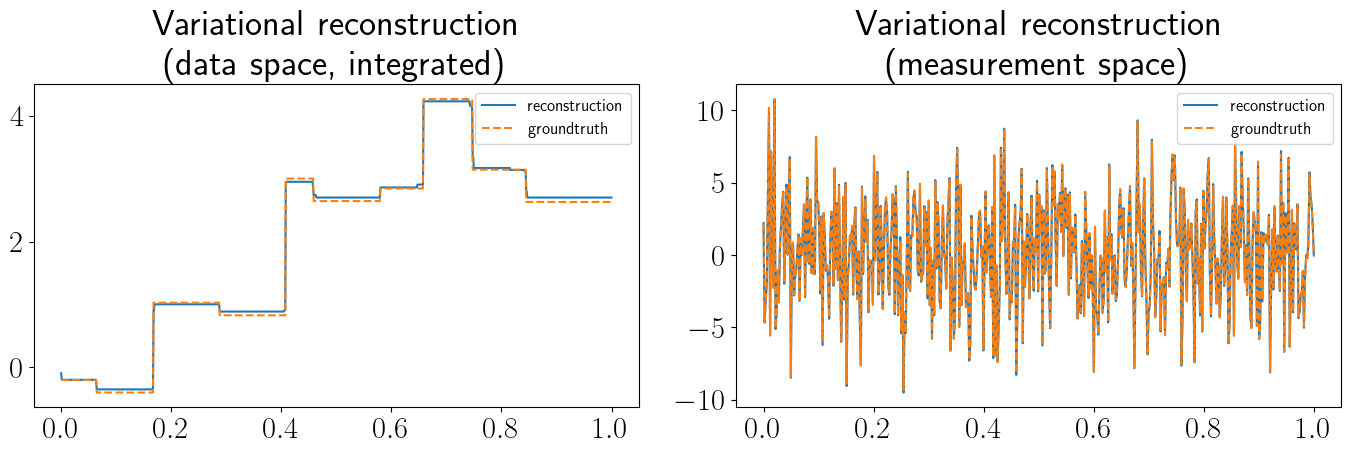

Loss: 0.06304
MSE: 0.00131


In [34]:
TV_ITERATIONS = 2_000
TV_LAMBDA = 1e0
TV_ALPHA = 3e0

loss_acc = 0.0
mse_acc = 0.0
for i, (noisy_measurement, groundtruth) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
    noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
    reconstruction, tv_loss, subgradient = TV_SOLVER(noisy_measurement)
    # ---------------- Evaluation --------------------
    loss_acc += tv_loss
    mse_acc += F.mse_loss(reconstruction, groundtruth).item()
    if i == 0:
        plt.subplots(1,2,figsize=(14,5))
        plt.subplot(1,2,1)
        plt.title("Variational reconstruction\n(data space, integrated)")
        plt.plot(torch.linspace(0.0, 1.0, reconstruction.cumsum(1).shape[1]), reconstruction.cumsum(1)[0].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, groundtruth.cumsum(1).shape[1]), groundtruth.cumsum(1)[0].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.subplot(1,2,2)
        plt.title("Variational reconstruction\n(measurement space)")
        plt.plot(torch.linspace(0.0, 1.0, A(reconstruction).shape[1]), A(reconstruction)[0].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, A(groundtruth).shape[1]), A(groundtruth)[0].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.show()
print(f"Loss: {loss_acc/len(test_dataloader):7.5f}")
print(f"MSE: {mse_acc/len(test_dataloader):7.5f}")

  0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_2278240/851132199.py:9: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:156.)
  A_T = lambda x: (__A.mT@x.unsqueeze(-1))[...,0].flip(1).cumsum(1).flip(1)
/tmp/ipykernel_2278240/851132199.py:9: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding det

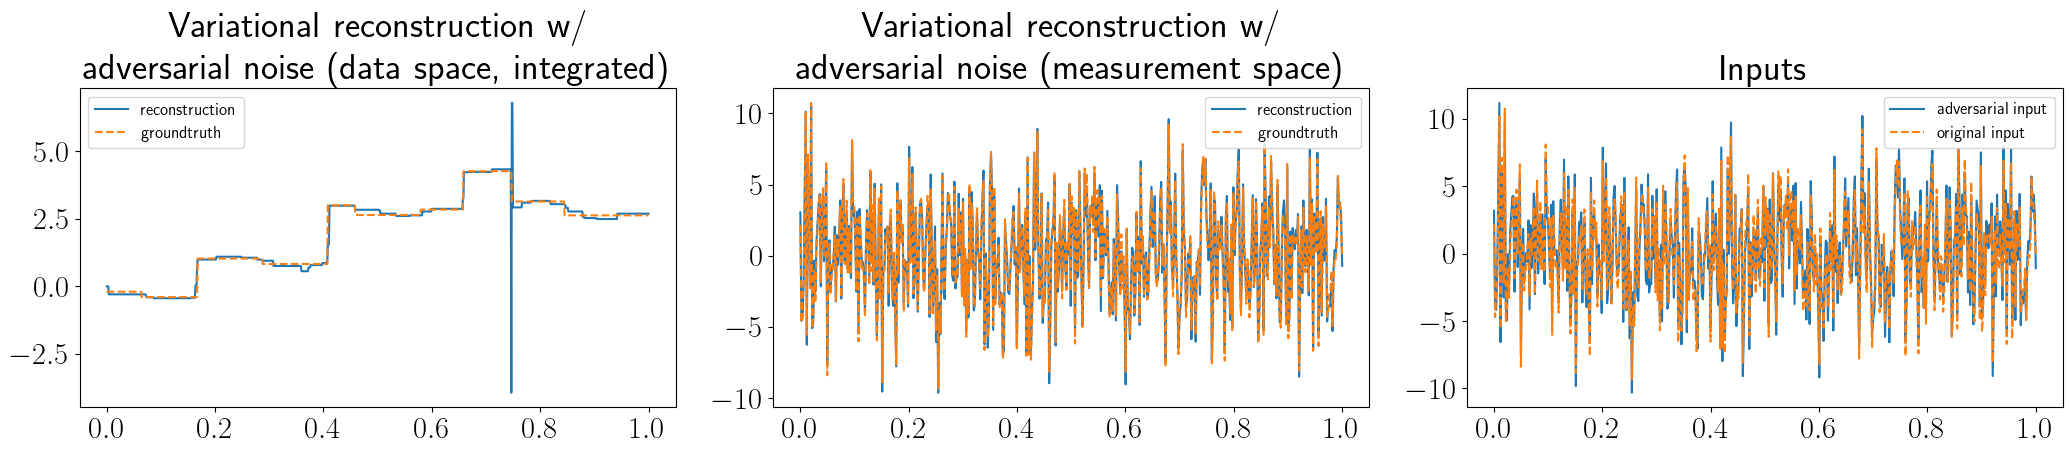

Loss: 0.55293
MSE: 0.24451


In [36]:
TV_ADV_LR = 1e0
TV_ADV_ITERATIONS = 10
TV_ADV_EPSILON = 1.0


loss_acc = 0.0
mse_acc = 0.0
for i, (noisy_measurement, groundtruth) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
    noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
    # ---------------- Adversarial attack ------------
    adversarial_measurement = noisy_measurement.clone()
    adversarial_measurement.requires_grad = True
    for _ in range(TV_ADV_ITERATIONS):
        with torch.enable_grad():
            reconstruction = TV_SOLVER(adversarial_measurement)[0]
            loss = F.mse_loss(reconstruction, groundtruth)
            loss.backward()
        adversarial_measurement = adversarial_measurement + TV_ADV_LR*torch.sign(adversarial_measurement.grad) # FGSM step
        adversarial_measurement = noisy_measurement + torch.clamp(adversarial_measurement-noisy_measurement, -TV_ADV_EPSILON, TV_ADV_EPSILON) # Projection
        adversarial_measurement.requires_grad = True
    # ---------------- Reconstruction ----------------
    reconstruction, tv_loss, subgradient = TV_SOLVER(adversarial_measurement)
    # ---------------- Evaluation --------------------
    loss_acc += tv_loss
    mse_acc += F.mse_loss(reconstruction, groundtruth).item()
    if i == 0:
        plt.subplots(1,3,figsize=(21,5))
        plt.subplot(1,3,1)
        plt.title("Variational reconstruction w/\nadversarial noise (data space, integrated)")
        plt.plot(torch.linspace(0.0, 1.0, reconstruction.shape[1]), reconstruction.cumsum(1)[0].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, groundtruth.shape[1]), groundtruth.cumsum(1)[0].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.subplot(1,3,2)
        plt.title("Variational reconstruction w/\nadversarial noise (measurement space)")
        plt.plot(torch.linspace(0.0, 1.0, A(reconstruction).shape[1]), A(reconstruction)[0].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, A(groundtruth).shape[1]), A(groundtruth)[0].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.subplot(1,3,3)
        plt.title("Inputs")
        plt.plot(torch.linspace(0.0, 1.0, adversarial_measurement.shape[1]), adversarial_measurement[0].detach().to("cpu").numpy(), label="adversarial input")
        plt.plot(torch.linspace(0.0, 1.0, noisy_measurement.shape[1]), noisy_measurement[0].detach().to("cpu").numpy(), "--", label="original input")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.show()
print(f"Loss: {loss_acc/len(test_dataloader):7.5f}")
print(f"MSE: {mse_acc/len(test_dataloader):7.5f}")

### Post-processing U-Net

In [18]:
class UNet(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, depth: int = 4, base_channels: int = 64, *, dims: Union[Literal[1],Literal[2],Literal[3]] = 2) -> None:
        super().__init__()
        self.__depth = depth
        ConvType = [nn.Conv1d, nn.Conv2d, nn.Conv3d][dims-1]
        TransposeConvType = [nn.ConvTranspose1d, nn.ConvTranspose2d, nn.ConvTranspose3d][dims-1]
        MaxPoolType = [nn.MaxPool1d, nn.MaxPool2d, nn.MaxPool3d][dims-1]
        self.__down_blocks = nn.ModuleList(
            [
                nn.Sequential(
                    ConvType(in_channels, base_channels, kernel_size=3, padding=1),
                    nn.ReLU(),
                    ConvType(base_channels, base_channels, kernel_size=3, padding=1),
                    nn.ReLU(),
                )
            ]+[
                nn.Sequential(
                    MaxPoolType(2),
                    ConvType(base_channels*2**(i-1), base_channels*2**i, kernel_size=3, padding=1),
                    nn.ReLU(),
                    ConvType(base_channels*2**i, base_channels*2**i, kernel_size=3, padding=1),
                    nn.ReLU(),
                ) for i in range(1, depth)
            ]
        )
        self.__central_block = nn.Sequential(
            MaxPoolType(2),
            ConvType(base_channels*2**(depth-1), base_channels*2**depth, kernel_size=3, padding=1),
            nn.ReLU(),
            ConvType(base_channels*2**depth, base_channels*2**depth, kernel_size=3, padding=1),
            nn.ReLU(),
            TransposeConvType(base_channels*2**depth, base_channels*2**(depth-1), kernel_size=2, stride=2),
        )
        self.__up_blocks = nn.ModuleList(
            [
                nn.Sequential(
                    ConvType(base_channels*2**(i+1), base_channels*2**i, kernel_size=3, padding=1),
                    nn.ReLU(),
                    ConvType(base_channels*2**i, base_channels*2**i, kernel_size=3, padding=1),
                    nn.ReLU(),
                    TransposeConvType(base_channels*2**i, base_channels*2**(i-1), kernel_size=2, stride=2),
                ) for i in range(depth-1,0,-1)
            ]+[
                nn.Sequential(
                    ConvType(base_channels*2, base_channels, kernel_size=3, padding=1),
                    nn.ReLU(),
                    ConvType(base_channels, base_channels, kernel_size=3, padding=1),
                    nn.ReLU(),
                    ConvType(base_channels, out_channels, kernel_size=1),
                )
            ]
        )
    
    def forward(self, x: Tensor) -> Tensor:
        x = A_pinv(x)
        assert x.shape[-1]%2**self.__depth == 0, "Invalid input size"
        tmp = []
        delta = x
        for down_block in self.__down_blocks:
            delta = down_block(delta)
            tmp.append(delta)
        delta = self.__central_block(delta)
        for i, up_block in enumerate(self.__up_blocks):
            delta = torch.cat([delta, tmp[-(i+1)]], dim=1)
            delta = up_block(delta)
        return x+delta

/tmp/ipykernel_2278240/851132199.py:12: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:156.)
  A_pinv = lambda x: (__ATApaD2iAT@x.unsqueeze(-1))[...,0]


  0%|          | 0/5000 [00:00<?, ?it/s]

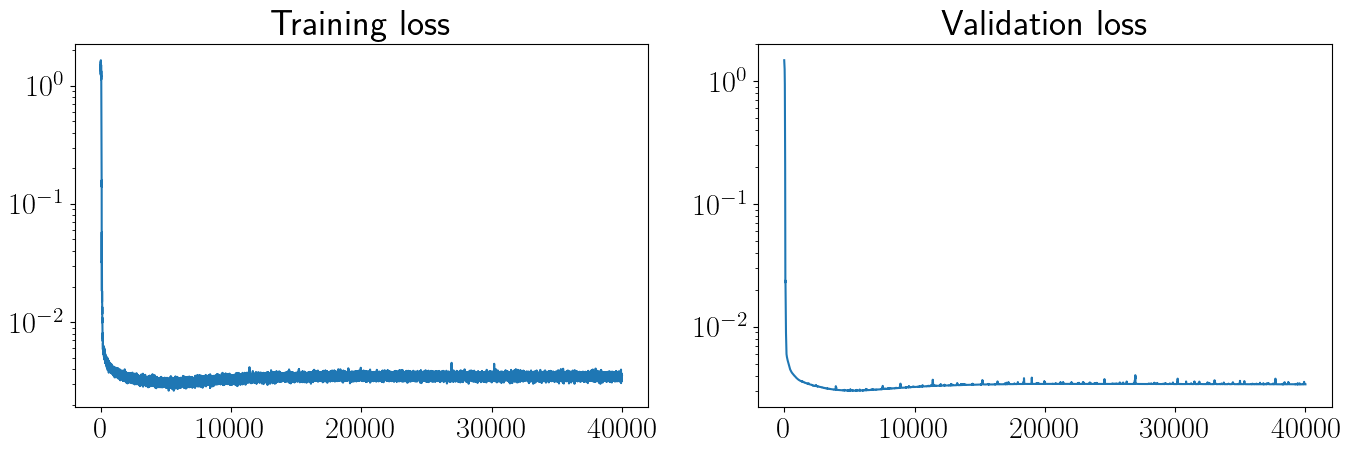

Loss: 0.00340
MSE: 0.24451


In [37]:
unet = UNet(1, 1, dims=1).to(DEVICE)
optimizer = torch.optim.Adam(unet.parameters(), lr=UNET_LR, weight_decay=1e-3)
UNET_LR = 1e-4
UNET_EPOCHS = 5000
train_losses = []
val_losses = []
loss_acc = 0.0
loss_fn = lambda a,b: F.smooth_l1_loss(a, b)
for noisy_measurement, groundtruth in val_dataloader:
    noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
    # ---------------- Forward ----------------
    reconstruction = unet(noisy_measurement.unsqueeze(1))[:,0]
    # ---------------- Evaluation -------------
    loss_acc += loss_fn(reconstruction, groundtruth).item()
val_losses.append(loss_acc/len(test_dataloader))
for _ in trange(UNET_EPOCHS):
    unet.train()
    for noisy_measurement, groundtruth in train_dataloader:
        noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
        # ---------------- Training ---------------
        with torch.enable_grad():
            reconstruction = unet(noisy_measurement.unsqueeze(1))[:,0]
            loss = loss_fn(reconstruction, groundtruth)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # ---------------- Evaluation -------------
        train_losses.append(loss_fn(reconstruction, groundtruth).item())
    unet.eval()
    loss_acc = 0.0
    for noisy_measurement, groundtruth in val_dataloader:
        noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
        # ---------------- Forward ----------------
        reconstruction = unet(noisy_measurement.unsqueeze(1))[:,0]
        # ---------------- Evaluation -------------
        loss_acc += loss_fn(reconstruction, groundtruth).item()
    val_losses.append(loss_acc/len(test_dataloader))
plt.subplots(1,2,figsize=(14,5))
plt.subplot(1,2,1)
plt.title("Training loss")
plt.yscale("log")
plt.plot(train_losses)
plt.yscale("log")
plt.subplot(1,2,2)
plt.title("Validation loss")
plt.yscale("log")
plt.plot([x*len(train_dataloader) for x in range(len(val_losses))], val_losses)
plt.yscale("log")
plt.tight_layout()
plt.show()
print(f"Loss: {loss_acc/len(test_dataloader):7.5f}")
print(f"MSE: {mse_acc/len(test_dataloader):7.5f}")

/tmp/ipykernel_2278240/851132199.py:12: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:156.)
  A_pinv = lambda x: (__ATApaD2iAT@x.unsqueeze(-1))[...,0]
/tmp/ipykernel_2278240/851132199.py:8: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic suppo

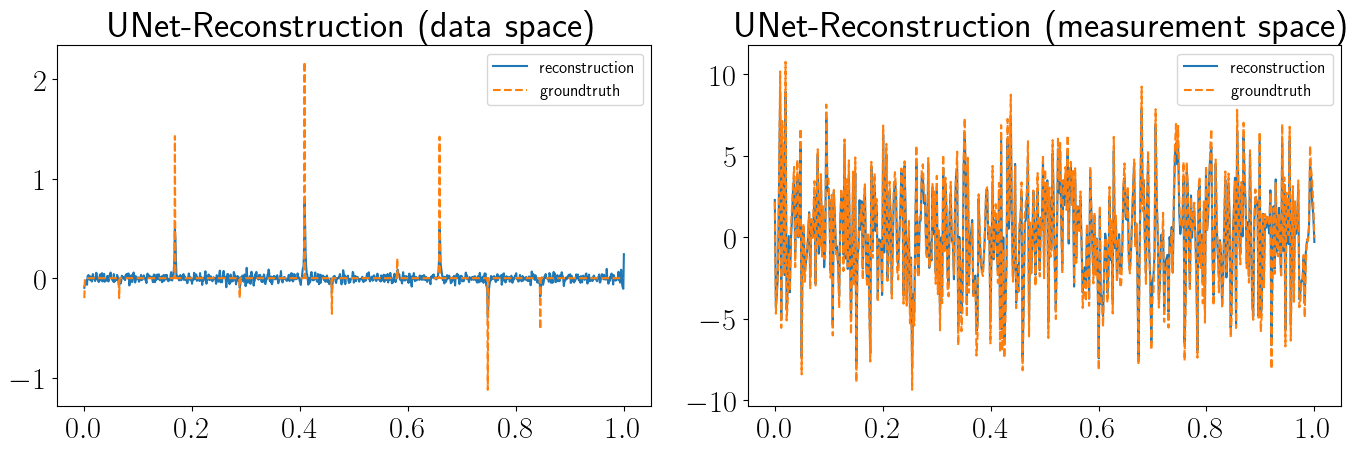

Loss: 0.00346
MSE: 0.00714


In [38]:
loss_acc = 0.0
mse_acc = 0.0
unet.eval()
for noisy_measurement, groundtruth in test_dataloader:
    noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
    # ---------------- Forward ----------------
    reconstruction = unet(noisy_measurement.unsqueeze(1))[:,0]
    # ---------------- Evaluation -------------
    loss_acc += loss_fn(reconstruction, groundtruth).item()
    mse_acc += F.mse_loss(reconstruction, groundtruth).item()
    if i == 0:
        plt.subplots(1,2,figsize=(14,5))
        plt.subplot(1,2,1)
        plt.title("UNet-Reconstruction (data space)")
        plt.plot(torch.linspace(0.0, 1.0, reconstruction.shape[1]), reconstruction[0].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, groundtruth.shape[1]), groundtruth[0].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.subplot(1,2,2)
        plt.title("UNet-Reconstruction (measurement space)")
        plt.plot(torch.linspace(0.0, 1.0, A(reconstruction).shape[1]), A(reconstruction)[0].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, A(groundtruth).shape[1]), A(groundtruth)[0].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.show()
print(f"Loss: {loss_acc/len(test_dataloader):7.5f}")
print(f"MSE: {mse_acc/len(test_dataloader):7.5f}")

/tmp/ipykernel_2278240/1165417344.py:4: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:71.)
  noisy_measurement, groundtruth = noisy_measurement.to(DEVICE).cumsum(1), groundtruth.to(DEVICE).cumsum(1)
/tmp/ipykernel_2278240/851132199.py:12: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to h

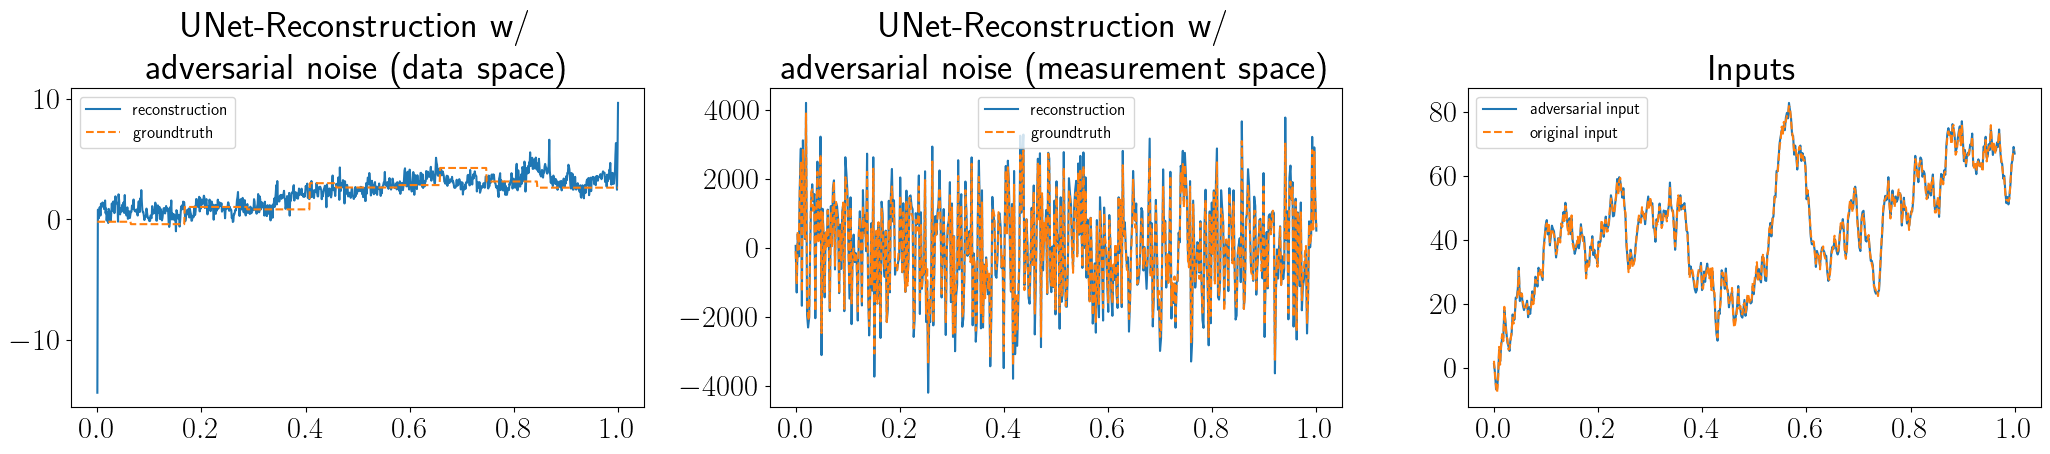

Loss: 0.82792
MSE: 3.24222


In [21]:
loss_acc = 0.0
mse_acc = 0.0
for noisy_measurement, groundtruth in test_dataloader:
    noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
    # ---------------- Adversarial attack ------------
    adversarial_measurement = noisy_measurement.clone()
    adversarial_measurement.requires_grad = True
    for _ in range(TV_ADV_ITERATIONS):
        with torch.enable_grad():
            reconstruction = unet(adversarial_measurement.unsqueeze(1))[:,0]
            loss = loss_fn(reconstruction, groundtruth)
            loss.backward()
        adversarial_measurement = adversarial_measurement + TV_ADV_LR*torch.sign(adversarial_measurement.grad) # FGSM step
        adversarial_measurement = noisy_measurement + torch.clamp(adversarial_measurement-noisy_measurement, -TV_ADV_EPSILON, TV_ADV_EPSILON) # Projection
        adversarial_measurement.requires_grad = True
    # ---------------- Reconstruction ----------------
    reconstruction = unet(adversarial_measurement.unsqueeze(1))[:,0]
    # ---------------- Evaluation --------------------
    loss_acc += loss_fn(reconstruction, groundtruth).item()
    mse_acc += F.mse_loss(reconstruction, groundtruth).item()
    if i == 0:
        plt.subplots(1,3,figsize=(21,5))
        plt.subplot(1,3,1)
        plt.title("UNet-Reconstruction w/\nadversarial noise (data space)")
        plt.plot(torch.linspace(0.0, 1.0, reconstruction.shape[1]), reconstruction[0].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, groundtruth.shape[1]), groundtruth[0].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.subplot(1,3,2)
        plt.title("UNet-Reconstruction w/\nadversarial noise (measurement space)")
        plt.plot(torch.linspace(0.0, 1.0, A(reconstruction).shape[1]), A(reconstruction)[0].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, A(groundtruth).shape[1]), A(groundtruth)[0].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.subplot(1,3,3)
        plt.title("Inputs")
        plt.plot(torch.linspace(0.0, 1.0, adversarial_measurement.shape[1]), adversarial_measurement[0].detach().to("cpu").numpy(), label="adversarial input")
        plt.plot(torch.linspace(0.0, 1.0, noisy_measurement.shape[1]), noisy_measurement[0].detach().to("cpu").numpy(), "--", label="original input")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.show()
print(f"Loss: {loss_acc/len(test_dataloader):7.5f}")
print(f"MSE: {mse_acc/len(test_dataloader):7.5f}")

### Tiramisu

In [22]:
class Tiramisu(nn.Module):
    class DenseBlock(nn.Module):
        def __init__(self, channels: int, layer_count: int, growth_rate: int, dims: int = 2) -> None:
            super().__init__()
            ConvType = [nn.Conv1d, nn.Conv2d, nn.Conv3d][dims-1]
            BatchNormType = [nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d][dims-1]
            DropoutType = [nn.Dropout1d, nn.Dropout2d, nn.Dropout3d][dims-1]
            self.__layers = nn.ModuleList([
                nn.Sequential(
                    BatchNormType(channels+i*growth_rate),
                    nn.ReLU(),
                    ConvType(channels+i*growth_rate, growth_rate, kernel_size=3, padding=1),
                    DropoutType(p=0.2),
                ) for i in range(layer_count)
            ])

        def forward(self, x: torch.Tensor) -> None:
            out = []
            tmp = [x]
            for layer in self.__layers:
                z = layer(torch.cat(tmp, dim=1))
                tmp.append(z)
                out.append(z)
            return torch.cat(out, dim=1)
        
    class DownBlock(nn.Module):
        def __init__(self, channels: int, layer_count: int, growth_rate: int, dims: int = 2) -> None:
            super().__init__()
            ConvType = [nn.Conv1d, nn.Conv2d, nn.Conv3d][dims-1]
            MaxPoolType = [nn.MaxPool1d, nn.MaxPool2d, nn.MaxPool3d][dims-1]
            BatchNormType = [nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d][dims-1]
            DropoutType = [nn.Dropout1d, nn.Dropout2d, nn.Dropout3d][dims-1]
            self.__down_trans = nn.Sequential(
                BatchNormType(channels),
                nn.ReLU(),
                ConvType(channels, channels, kernel_size=1),
                DropoutType(0.2),
                MaxPoolType(2),
            )
            self.__dense_block = Tiramisu.DenseBlock(channels, layer_count, growth_rate, dims)

        def forward(self, x: torch.Tensor) -> None:
            x = self.__down_trans(x)
            return torch.cat([x, self.__dense_block(x)], dim=1)
        
    def __init__(self, in_channels: int, out_channels: int, layer_counts: Sequence[int] = [4,5,7,10,12,15], growth_rate: int = 16, base_channels: int = 48, *, dims: Union[Literal[1],Literal[2],Literal[3]] = 2) -> None:
        super().__init__()
        ConvType = [nn.Conv1d, nn.Conv2d, nn.Conv3d][dims-1]
        TransposeConvType = [nn.ConvTranspose1d, nn.ConvTranspose2d, nn.ConvTranspose3d][dims-1]
        self.__initial_conv = ConvType(in_channels, base_channels, kernel_size=3, padding=1)
        down_channels = base_channels+torch.tensor(layer_counts).cumsum(0)*growth_rate
        self.__down_blocks = nn.ModuleList(
            [Tiramisu.DenseBlock(base_channels, layer_counts[0], growth_rate, dims)]+
            [Tiramisu.DownBlock(down_channels[i], layer_count, growth_rate, dims) for i, layer_count in enumerate(layer_counts[1:-1])])
        self.__central_block = nn.Sequential(
            Tiramisu.DownBlock(down_channels[-2], layer_counts[-1], growth_rate, dims),
            TransposeConvType(down_channels[-1], down_channels[-1]//2, kernel_size=3, stride=2, padding=1, output_padding=1),
        )
        up_channels = down_channels.flip(0)[:-1]+torch.tensor(layer_counts)[:-1].flip(0)*growth_rate
        self.__up_blocks = nn.ModuleList([
            nn.Sequential(
                Tiramisu.DenseBlock(down_channels[-1]//2+down_channels[-2] if i == 0 else up_channels[i-1]//2, layer_count, growth_rate, dims),
                #TransposeConvType(up_channels[i], up_channels[i]//2, kernel_size=3, stride=2, padding=1, output_padding=1),
            ) for i, layer_count in enumerate(layer_counts[:-1][:0:-1])
        ]+[Tiramisu.DenseBlock(up_channels[-1]//2, layer_counts[0], growth_rate, dims)])
        self.__final_conv = ConvType(2**7, out_channels, kernel_size=1)
    
    def forward(self, x: Tensor) -> Tensor:
        x = self.__initial_conv(x)
        tmp = []
        for i, down_block in enumerate(self.__down_blocks):
            if i == 0:
                x = torch.cat([x, down_block(x)], dim=1)
            else:
                x = down_block(x)
            tmp.append(x)
        x = self.__central_block(x)
        [print(x.shape, end="    ") for x in tmp]
        print()
        print(x.shape)
        for i, up_block in enumerate(self.__up_blocks):
            x = torch.cat([x, tmp[-(i+1)]], dim=1)
            print(x.shape)
            x = up_block(x)
            print(x.shape)
        return self.__final_conv(x)
        

In [23]:
print(Tiramisu(1, 1, dims=1)(torch.randn(32,1,1024)).shape)

torch.Size([32, 112, 1024])    torch.Size([32, 192, 512])    torch.Size([32, 304, 256])    torch.Size([32, 464, 128])    torch.Size([32, 656, 64])    
torch.Size([32, 448, 64])
torch.Size([32, 1104, 64])
torch.Size([32, 192, 64])


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 64 but got size 128 for tensor number 1 in the list.

In [ ]:
tiramisu = Tiramisu(1, 1, dims=1).to(DEVICE)
optimizer = torch.optim.Adam(unet.parameters(), lr=UNET_LR)
train_losses = []
val_losses = []
for noisy_measurement, groundtruth in val_dataloader:
    noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
    # ---------------- Forward ----------------
    reconstruction = unet(noisy_measurement.unsqueeze(1))[:,0]
    # ---------------- Evaluation -------------
    loss_acc += F.mse_loss(reconstruction, groundtruth).item()
val_losses.append(loss_acc/len(test_dataloader))
for _ in trange(UNET_EPOCHS):
    tiramisu.train()
    for noisy_measurement, groundtruth in train_dataloader:
        noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
        # ---------------- Training ---------------
        with torch.enable_grad():
            reconstruction = tiramisu(noisy_measurement.unsqueeze(1))[:,0]
            loss = F.mse_loss(reconstruction, groundtruth)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # ---------------- Evaluation -------------
        train_losses.append(F.mse_loss(reconstruction, groundtruth).item())
    tiramisu.eval()
    for noisy_measurement, groundtruth in val_dataloader:
        noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
        # ---------------- Forward ----------------
        reconstruction = tiramisu(noisy_measurement.unsqueeze(1))[:,0]
        # ---------------- Evaluation -------------
        loss_acc += F.mse_loss(reconstruction, groundtruth).item()
    val_losses.append(loss_acc/len(test_dataloader))
plt.subplots(1,2,figsize=(14,5))
plt.subplot(1,2,1)
plt.title("Training loss")
plt.yscale("log")
plt.plot(train_losses)
plt.subplot(1,2,2)
plt.title("Validation loss")
plt.yscale("log")
plt.plot([x*len(train_dataloader) for x in range(len(val_losses))], val_losses)
plt.tight_layout()
plt.show()
print(f"Loss: {loss_acc/len(test_dataloader):7.5f}")
print(f"MSE: {mse_acc/len(test_dataloader):7.5f}")
print(f"Mean bregman distance: {bregman_acc/len(test_dataloader):7.5f}")

In [ ]:
loss_acc = 0.0
mse_acc = 0.0
tiramisu.eval()
for noisy_measurement, groundtruth in test_dataloader:
    noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
    # ---------------- Forward ----------------
    reconstruction = tiramisu(noisy_measurement.unsqueeze(1))[:,0]
    # ---------------- Evaluation -------------
    loss_acc += F.mse_loss(reconstruction, groundtruth).item()
    mse_acc += F.mse_loss(reconstruction, groundtruth).item()
    if i == 0:
        plt.figure(figsize=(7,5))
        plt.title("Tiramisu-Reconstruction")
        plt.plot(reconstruction[0].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(groundtruth[0].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.show()
print(f"Loss: {loss_acc/len(test_dataloader):7.5f}")
print(f"MSE: {mse_acc/len(test_dataloader):7.5f}")

In [ ]:
loss_acc = 0.0
mse_acc = 0.0
for noisy_measurement, groundtruth in test_dataloader:
    noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
    # ---------------- Adversarial attack ------------
    adversarial_measurement = noisy_measurement.clone()
    adversarial_measurement.requires_grad = True
    for _ in range(TV_ADV_ITERATIONS):
        with torch.enable_grad():
            reconstruction = tiramisu(adversarial_measurement.unsqueeze(1))[:,0]
            loss = -F.mse_loss(reconstruction, groundtruth)
            loss.backward()
        adversarial_measurement = adversarial_measurement + TV_ADV_LR*torch.sign(adversarial_measurement.grad) # FGSM step
        adversarial_measurement = noisy_measurement + torch.clamp(adversarial_measurement-noisy_measurement, -TV_ADV_EPSILON, TV_ADV_EPSILON) # Projection
        adversarial_measurement.requires_grad = True
    # ---------------- Reconstruction ----------------
    reconstruction = tiramisu(adversarial_measurement.unsqueeze(1))[:,0]
    # ---------------- Evaluation --------------------
    loss_acc += F.mse_loss(reconstruction, groundtruth).item()
    mse_acc += F.mse_loss(reconstruction, groundtruth).item()
    if i == 0:
        plt.subplots(1,2,figsize=(14,5))
        plt.subplot(1,2,1)
        plt.title("Tiramisu-Reconstruction w/ adversarial noise")
        plt.plot(torch.linspace(0.0, 1.0, reconstruction.shape[1]), reconstruction[0].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, groundtruth.shape[1]), groundtruth[0].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.subplot(1,2,2)
        plt.title("Inputs")
        plt.plot(torch.linspace(0.0, 1.0, adversarial_measurement.shape[1]), adversarial_measurement[0].detach().to("cpu").numpy(), label="adversarial input")
        plt.plot(torch.linspace(0.0, 1.0, noisy_measurement.shape[1]), noisy_measurement[0].detach().to("cpu").numpy(), "--", label="original input")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.show()
print(f"Loss: {loss_acc/len(test_dataloader):7.5f}")
print(f"MSE: {mse_acc/len(test_dataloader):7.5f}")

### ItNet

In [ ]:
class Generator(torch.nn.Module):
    def __init__(self, latent_size: int) -> None:
        super().__init__()
        self.__layers = nn.Sequential(
            nn.Linear(latent_size, MEASUREMENT_SIZE),
            nn.ReLU(),
            UNet(1, 1, dims=1)
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.__layers(x)
    
class Discriminator(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.__layers = nn.Sequential(
            UNet(1, 1, dims=1),
            nn.ReLU(),
            nn.Linear(MEASUREMENT_SIZE, 1),
            nn.Sigmoid(),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.__layers(x)

generator = Generator(50).to(DEVICE)
discriminator = Discriminator().to(DEVICE)
optimizer = torch.optim.Adam(list(generator.parameters())+list(discriminator.parameters()), lr=1e-6)
train_losses_g = []
train_losses_d = []
for _ in trange(3):
    unet.train()
    for _, real in train_dataloader:
        real = real.to(DEVICE)
        # ---------------- Training ---------------
        with torch.enable_grad():
            fake = generator(torch.randn((real.shape[0],1,50), device=DEVICE))[:,0]
            data = torch.cat([fake,real], dim=0)
            labels = torch.ones((data.shape[0],1), device=DEVICE)
            labels[:fake.shape[0]] = 0.0
            predictions = discriminator(data.unsqueeze(1))[:,0]
            loss = F.cross_entropy(predictions, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # ---------------- Evaluation -------------
        train_losses.append(F.cross_entropy(predictions, labels).item())
plt.subplots(1,2,figsize=(14,5))
plt.subplot(1,2,1)
plt.title("Training loss")
plt.yscale("log")
plt.plot(train_losses)
plt.subplot(1,2,2)
plt.title("Validation loss")
plt.yscale("log")
plt.plot([x*len(train_dataloader) for x in range(len(val_losses))], val_losses)
plt.tight_layout()
plt.show()

plt.subplots(2,2,figsize=(7,5))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(generator(torch.randn((1,1,50), device=DEVICE)).detach().to("cpu").numpy()[0,0])
plt.tight_layout()
plt.show()